In [34]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from math import pow, inf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [26]:
# map a grid/action pair to the index of the corresponding q value in self.qs
def sa_to_id(grid,action,player):
    # map grid to a 9 digit trinary number, then change the number to decimal, then add action * 3^9, finally add 9*3^9 if player is O
    flat_grid = grid.flatten()
    digits = np.array([ x+1 for x in flat_grid])
    index = 0
    for i in range(9):
        index += digits[i] * pow(3,i)
    index += pow(3,9) * action
    if (player == 'O'):
        index += 177147
    return int(index)


class QPlayer:
    '''
    the player stores the Q value of the grid/action pair when he's X as well as when he's O
    not every grid and action are valid. For example, grid where there's 3 O and zero X, or a action that place piece on existing piece.
    We keep all available grid and action never the less, for simplicity.
    '''
    def __init__(self,epsilon=0.2,player='X'):
        self.player = player
        self.qs = np.zeros(177147*2)
        self.previous_q = -1
        self.lr = 0.05
        self.d_factor = 0.99
        self.epsi = epsilon
    def set_player(self,player):
        self.player = player
    def act(self, grid, reward):
        #first, find all available actions
        actions = [a for a in range(9) if grid[(int(a/3), a % 3)] == 0]
        possible_qs = [self.qs[sa_to_id(grid,a,self.player)] for a in actions]
        best = np.argmax(possible_qs)
        best_a = actions[ best ]
        highest_q = possible_qs[best]
        #then, update q value from previous time step
        if not self.previous_q == -1:
            delta = self.lr * (reward + self.d_factor * highest_q - self.qs[self.previous_q])
            self.qs[self.previous_q] = self.qs[self.previous_q] + delta
        #then, choose a action according to policy, and save current q value's index
        if random.uniform(0, 1) > self.epsi:
            at = best_a
        else:
            if len(actions) > 1: actions.pop(best)
            at = random.choice(actions)
        self.previous_q = sa_to_id(grid,at,self.player)
               
        return at
    def terminal(self, reward):
        if self.previous_q == -1:
            return
        delta = self.lr * (reward + 0 - self.qs[self.previous_q])
        self.qs[self.previous_q] = self.qs[self.previous_q] + delta
        #set previous_q to -1 because game will restart
        self.previous_q = -1
        
   

In [27]:
grid = np.array([[1,-1,0],[0,0,1],[-1,0,1]])

sa_to_id(grid,0,'X')
i = 3

print(grid[ (int(i/3), i % 3) ])

0


In [28]:
turns = np.array(['X','O'])

In [29]:
turns = turns[[1,0]]
print(turns)

['O' 'X']


In [30]:
env = TictactoeEnv()
turns = np.array(['X','O'])
player_opt = OptimalPlayer(epsilon=0.5)
player_q = QPlayer(epsilon= 0.5)
average_rewards = []
period_rewards = []

In [31]:
for i in tqdm(range(20000)):
    #each game
    env.reset()
    grid, _, __ = env.observe()
    turns = turns[[1,0]]
    player_opt.set_player(turns[0])
    player_q.set_player(turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_q.act(grid,0)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            if winner == player_q.player:
                reward = 1
            elif winner == player_opt.player:
                reward = -1
            else:
                reward = 0
            player_q.terminal(reward)
            
            period_rewards.append(reward)
            if len(period_rewards) >= 50:
                average_rewards.append(np.mean(period_rewards))
                period_rewards = []
            break

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:50<00:00, 180.97it/s]


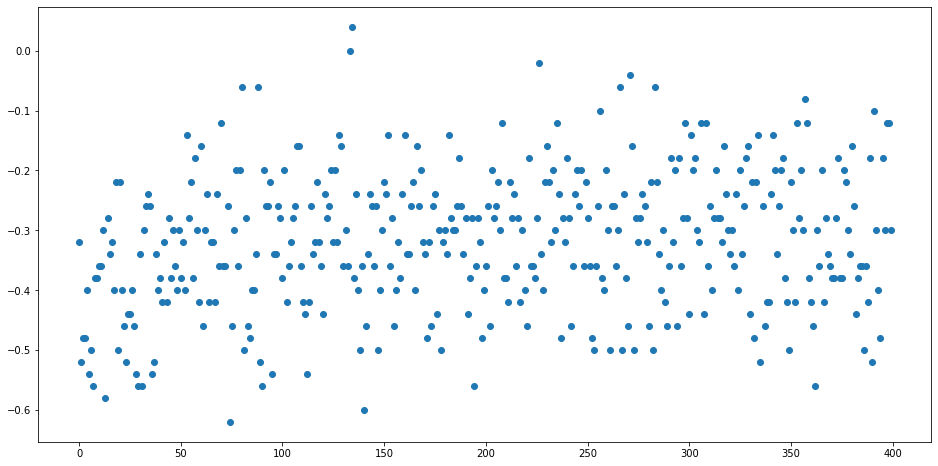

In [37]:
fig,ax = plt.subplots(figsize = (16,8))
ax.scatter(range(len(average_rewards)),average_rewards)